## 1. Import Libraries

In [21]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions

from sklearn.ensemble import IsolationForest

## 2. Read the Training Data

In [22]:
file_path = r"C:\Sahil\portfolio\Flight-Fare-Forecasting-with-AWS-SageMaker\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-05-15,Delhi,Cochin,04:55:00,21:00:00,965,1.0,No Info,6979
1,Jet Airways,2019-03-27,Delhi,Cochin,09:00:00,18:50:00,590,1.0,In-flight meal not included,5963
2,Indigo,2019-06-12,Delhi,Cochin,16:00:00,01:30:00,570,1.0,No Info,6316
3,Indigo,2019-04-12,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,4823
4,Indigo,2019-05-18,Kolkata,Banglore,18:05:00,23:30:00,325,1.0,No Info,6704
...,...,...,...,...,...,...,...,...,...,...
635,Air India,2019-05-24,Kolkata,Banglore,07:00:00,20:25:00,805,1.0,No Info,10413
636,Indigo,2019-06-12,Chennai,Kolkata,11:35:00,14:00:00,145,0.0,No Info,3858
637,Jet Airways,2019-03-27,Delhi,Cochin,09:00:00,18:50:00,590,1.0,No Info,12032
638,Jet Airways,2019-03-24,Kolkata,Banglore,13:55:00,04:45:00,890,1.0,In-flight meal not included,10661


### 2.1 Fixing Data Types

In [23]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [24]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [25]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-05-15,Delhi,Cochin,2024-05-26 04:55:00,2024-05-26 21:00:00,965,1.0,No Info,6979
1,Jet Airways,2019-03-27,Delhi,Cochin,2024-05-26 09:00:00,2024-05-26 18:50:00,590,1.0,In-flight meal not included,5963
2,Indigo,2019-06-12,Delhi,Cochin,2024-05-26 16:00:00,2024-05-26 01:30:00,570,1.0,No Info,6316
3,Indigo,2019-04-12,Banglore,Delhi,2024-05-26 13:00:00,2024-05-26 15:50:00,170,0.0,No Info,4823
4,Indigo,2019-05-18,Kolkata,Banglore,2024-05-26 18:05:00,2024-05-26 23:30:00,325,1.0,No Info,6704
...,...,...,...,...,...,...,...,...,...,...
635,Air India,2019-05-24,Kolkata,Banglore,2024-05-26 07:00:00,2024-05-26 20:25:00,805,1.0,No Info,10413
636,Indigo,2019-06-12,Chennai,Kolkata,2024-05-26 11:35:00,2024-05-26 14:00:00,145,0.0,No Info,3858
637,Jet Airways,2019-03-27,Delhi,Cochin,2024-05-26 09:00:00,2024-05-26 18:50:00,590,1.0,No Info,12032
638,Jet Airways,2019-03-24,Kolkata,Banglore,2024-05-26 13:55:00,2024-05-26 04:45:00,890,1.0,In-flight meal not included,10661


## 3. High-level Summary of Data

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [27]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,633.320312,0.803125,8951.612500
std,512.720916,0.693355,4987.132616
min,75.000000,0.000000,1965.000000
25%,170.000000,0.000000,5082.500000
50%,490.000000,1.000000,8025.000000
75%,932.500000,1.000000,12242.000000
max,2300.000000,3.000000,54826.000000


In [28]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,213,261,261,332.0,512


## 4. High-level analysis of Missing Values

In [29]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## 5. High-level analysis of Outliers

In [30]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [31]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
6,Multiple Carriers,2019-06-12,Delhi,Cochin,2024-05-26 17:50:00,2024-05-26 01:30:00,460,2.0,No Info,18275,-1
7,Jet Airways,2019-05-15,Kolkata,Banglore,2024-05-26 20:25:00,2024-05-26 14:25:00,1080,1.0,No Info,11467,-1
9,Jet Airways,2019-05-27,Delhi,Cochin,2024-05-26 09:00:00,2024-05-26 04:25:00,1165,1.0,In-flight meal not included,12898,-1
13,Vistara,2019-06-15,Delhi,Cochin,2024-05-26 14:40:00,2024-05-26 17:50:00,190,0.0,No Info,6216,-1
14,Jet Airways,2019-06-03,Delhi,Cochin,2024-05-26 16:00:00,2024-05-26 12:35:00,1235,1.0,In-flight meal not included,10262,-1
...,...,...,...,...,...,...,...,...,...,...,...
624,Multiple Carriers,2019-05-18,Delhi,Cochin,2024-05-26 17:50:00,2024-05-26 01:30:00,460,2.0,No Info,19360,-1
626,Multiple Carriers,2019-06-12,Delhi,Cochin,2024-05-26 11:35:00,2024-05-26 01:30:00,835,3.0,No Info,15419,-1
628,Indigo,2019-03-21,Chennai,Kolkata,2024-05-26 13:20:00,2024-05-26 15:35:00,135,0.0,No Info,3384,-1
631,Air India,2019-05-21,Mumbai,Hyderabad,2024-05-26 19:30:00,2024-05-26 20:45:00,75,0.0,No Info,3100,-1


## 6. Pair Plots

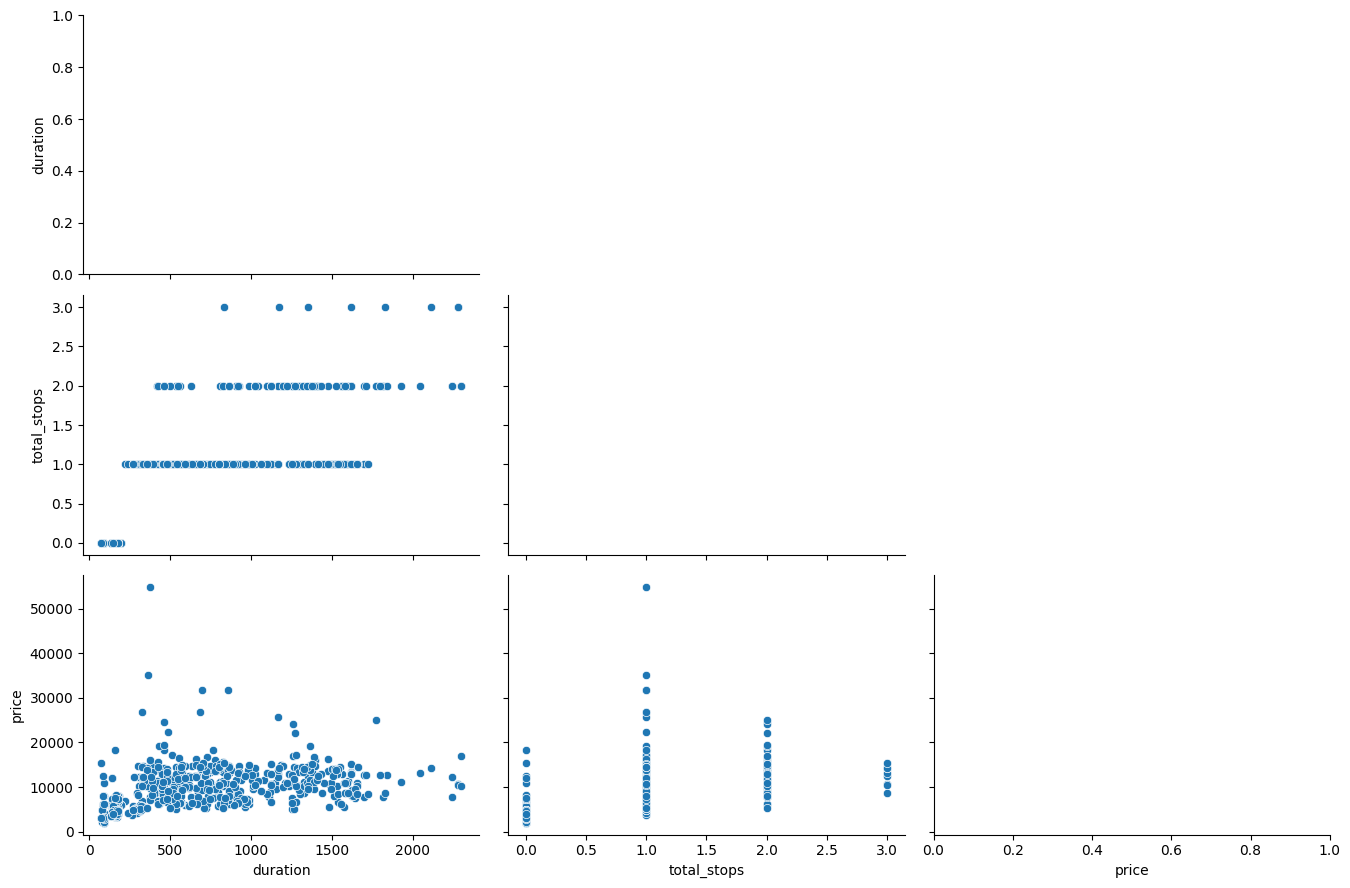

In [32]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

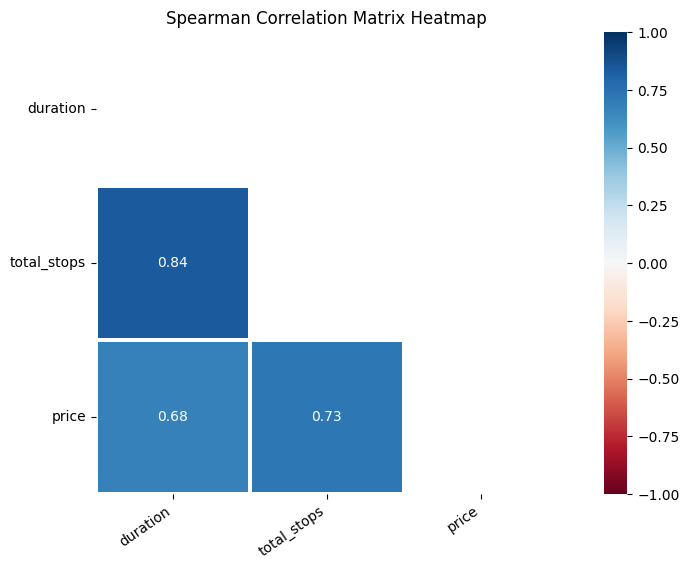

In [33]:
eda_helper_functions.correlation_heatmap(train)

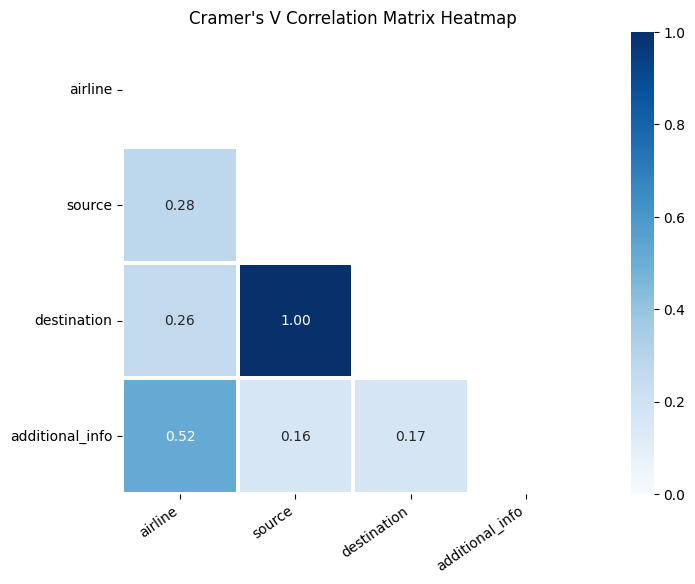

In [34]:
eda_helper_functions.cramersV_heatmap(train)

## 8. Detailed Analysis

In [35]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [36]:
train.airline

0           Indigo
1      Jet Airways
2           Indigo
3           Indigo
4           Indigo
          ...     
635      Air India
636         Indigo
637    Jet Airways
638    Jet Airways
639          Goair
Name: airline, Length: 640, dtype: object

In [37]:
eda_helper_functions.cat_summary(train, "airline")

0           Indigo
1      Jet Airways
2           Indigo
3           Indigo
4           Indigo
          ...     
635      Air India
636         Indigo
637    Jet Airways
638    Jet Airways
639          Goair
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,213


,count,percentage
category,,
Jet Airways,213,0.332813
Indigo,134,0.209375
Air India,112,0.175000
Multiple Carriers,72,0.112500
Spicejet,40,0.062500
Vistara,33,0.051562
Air Asia,25,0.039062
Goair,11,0.017188


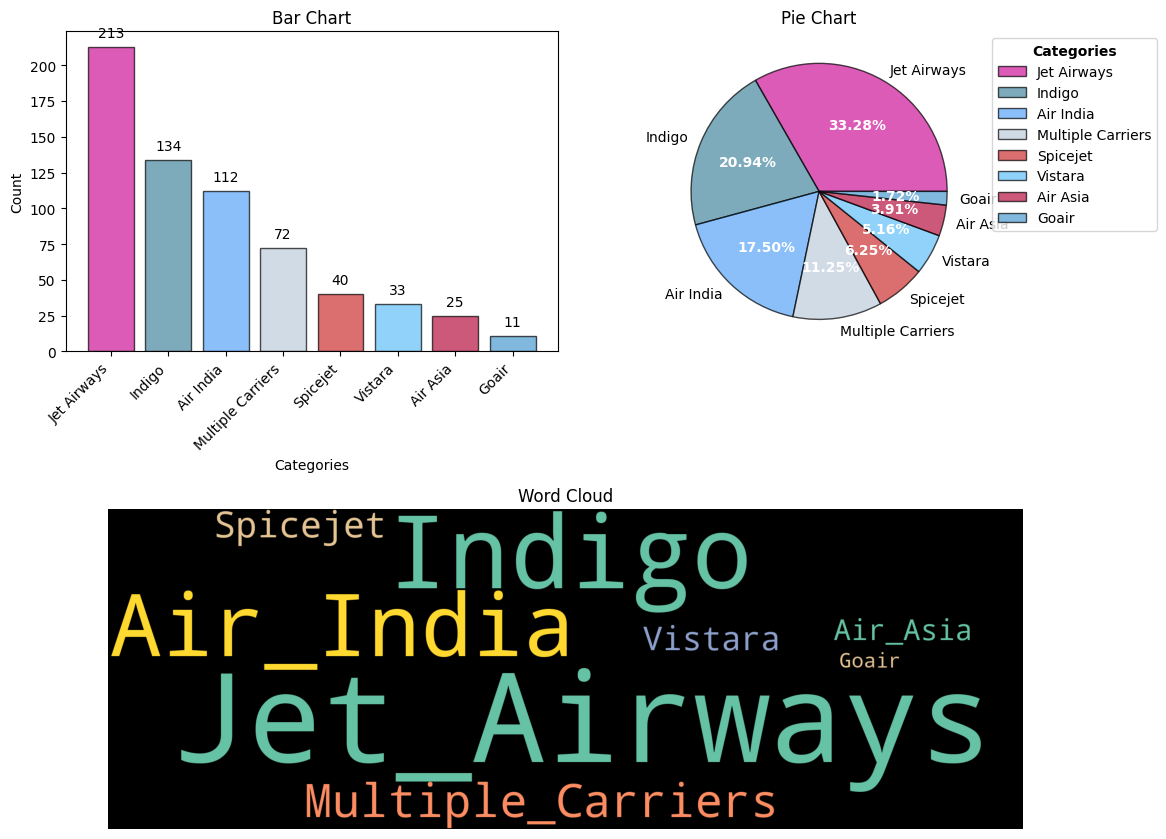

In [38]:
eda_helper_functions.cat_univar_plots(train, "airline")

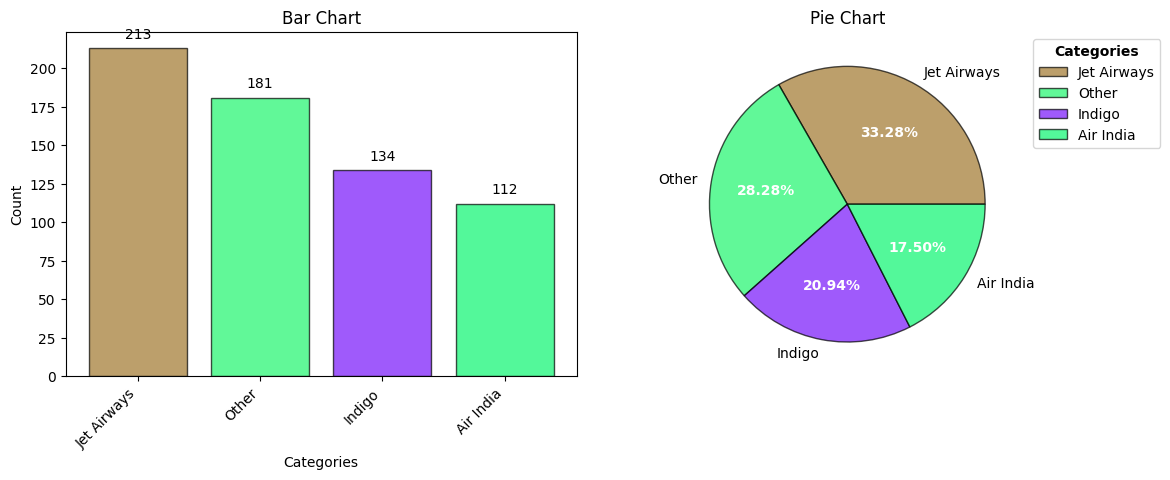

In [39]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)

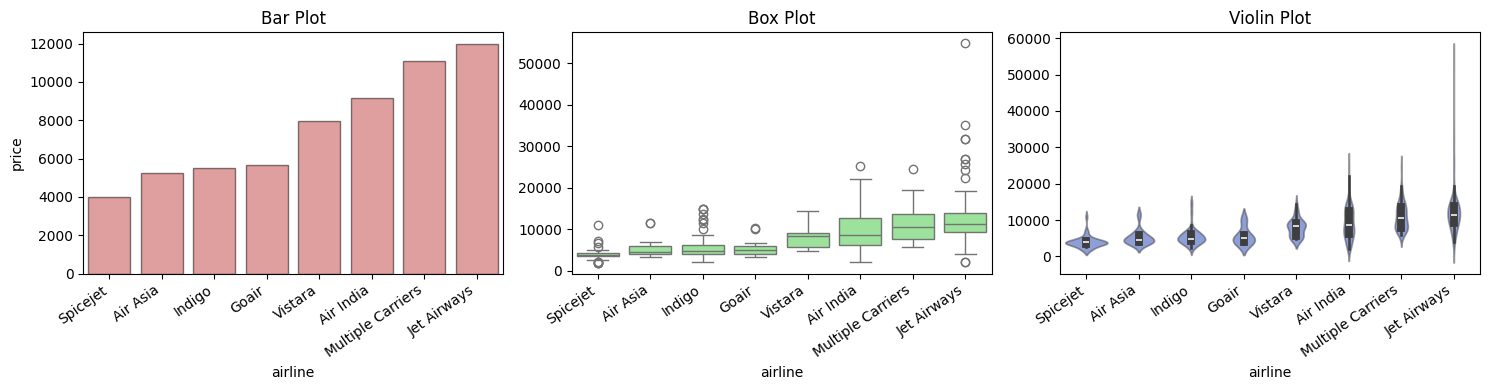

In [40]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [41]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 46.13798781928794
- p-value              : 8.197835696479722e-53
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 296.20680821130566
- p-value              : 3.905604316257592e-60
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


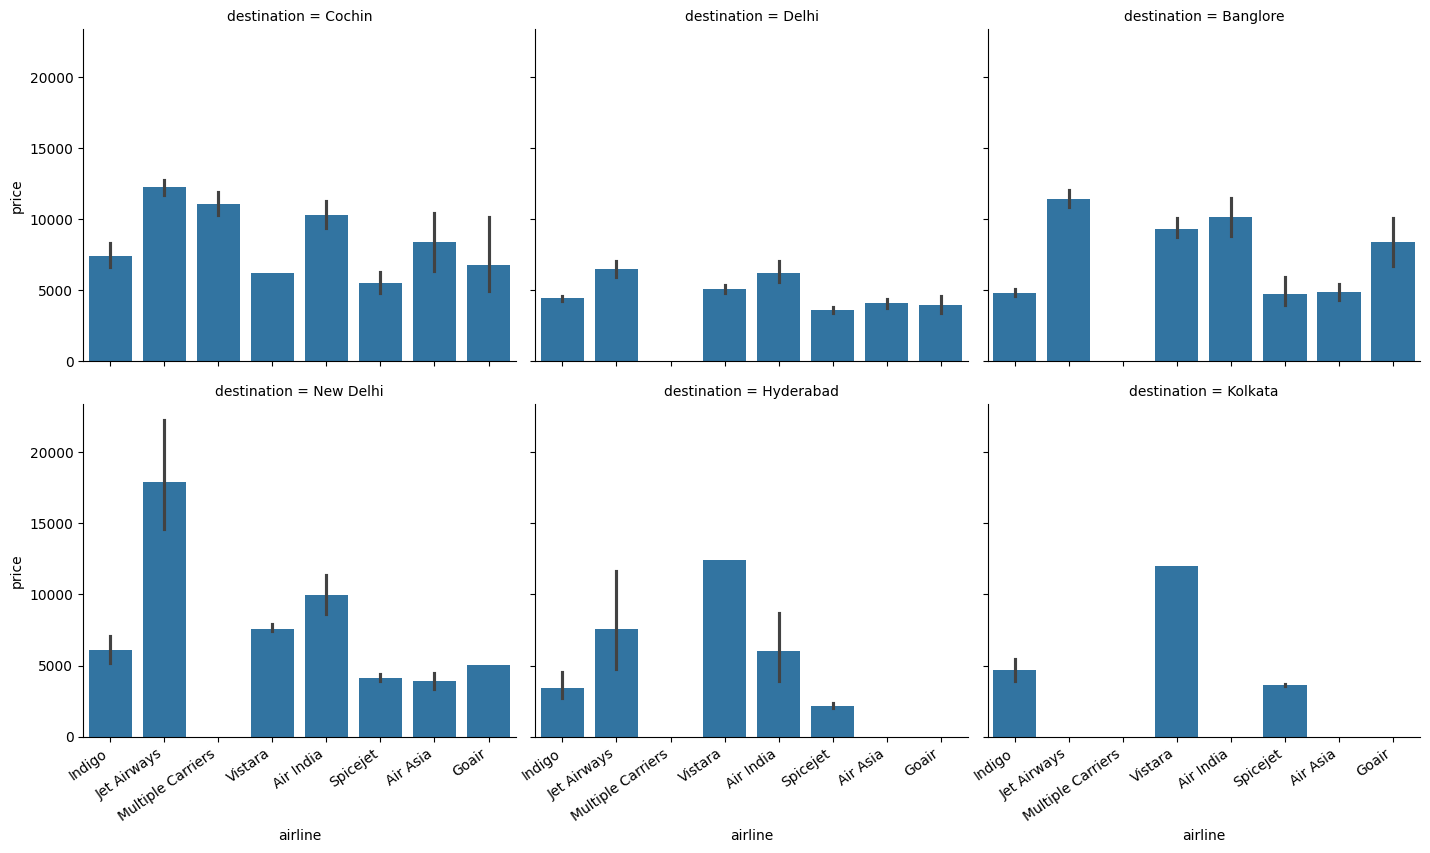

In [42]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [43]:
train.date_of_journey

0     2019-05-15
1     2019-03-27
2     2019-06-12
3     2019-04-12
4     2019-05-18
         ...    
635   2019-05-24
636   2019-06-12
637   2019-03-27
638   2019-03-24
639   2019-06-24
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

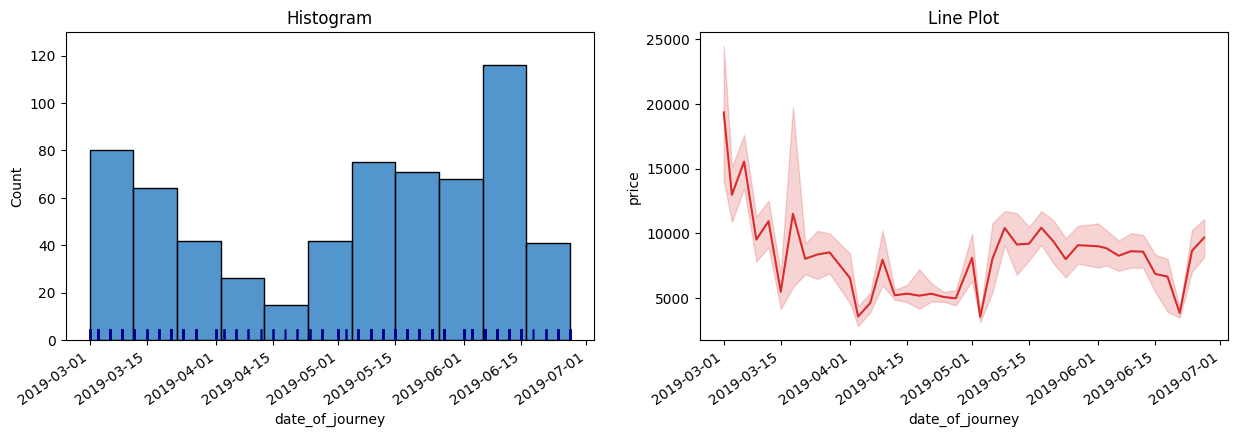

In [44]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

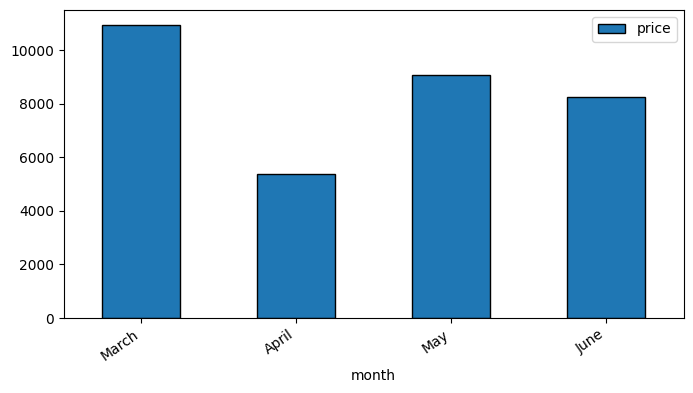

In [45]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

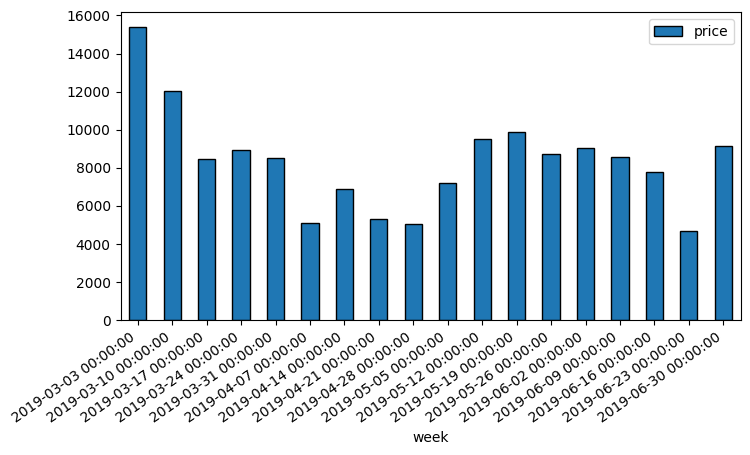

In [46]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

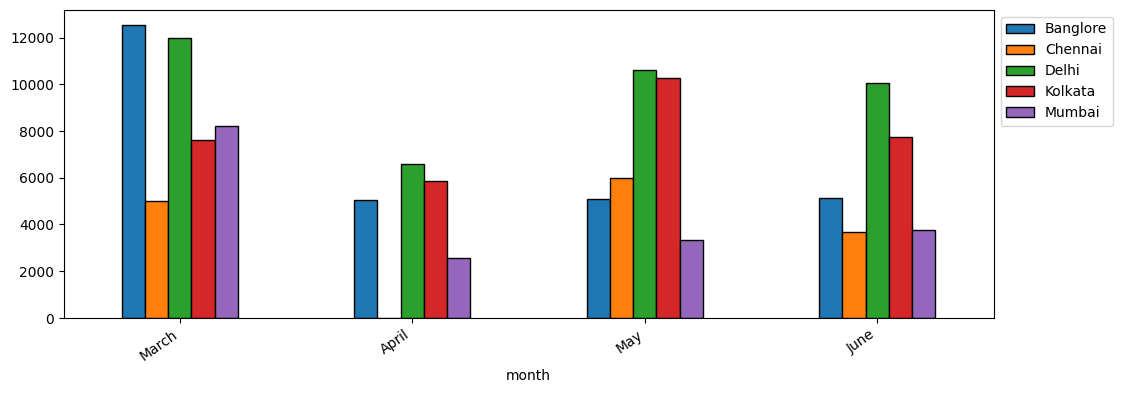

In [47]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [48]:
train.dep_time

0     2024-05-26 04:55:00
1     2024-05-26 09:00:00
2     2024-05-26 16:00:00
3     2024-05-26 13:00:00
4     2024-05-26 18:05:00
              ...        
635   2024-05-26 07:00:00
636   2024-05-26 11:35:00
637   2024-05-26 09:00:00
638   2024-05-26 13:55:00
639   2024-05-26 07:00:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

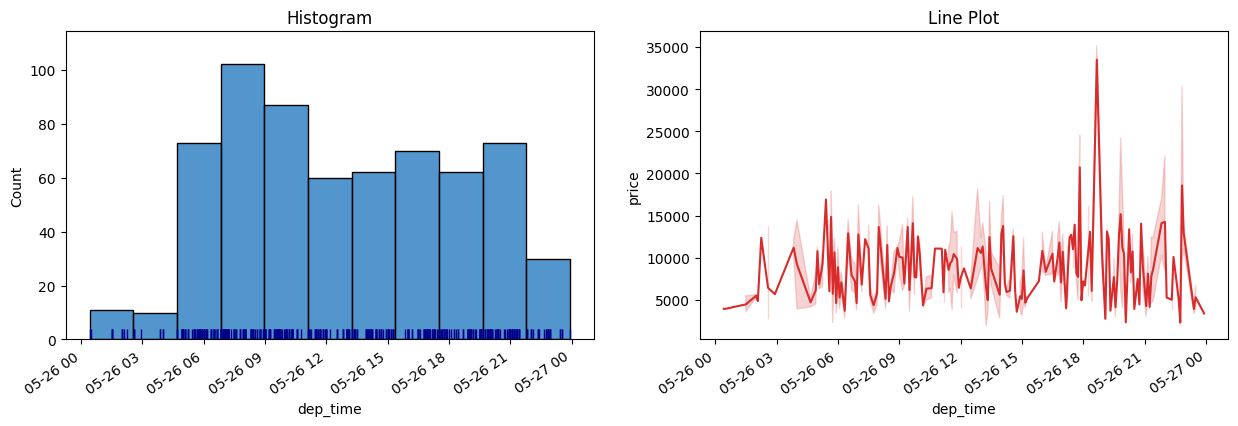

In [49]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

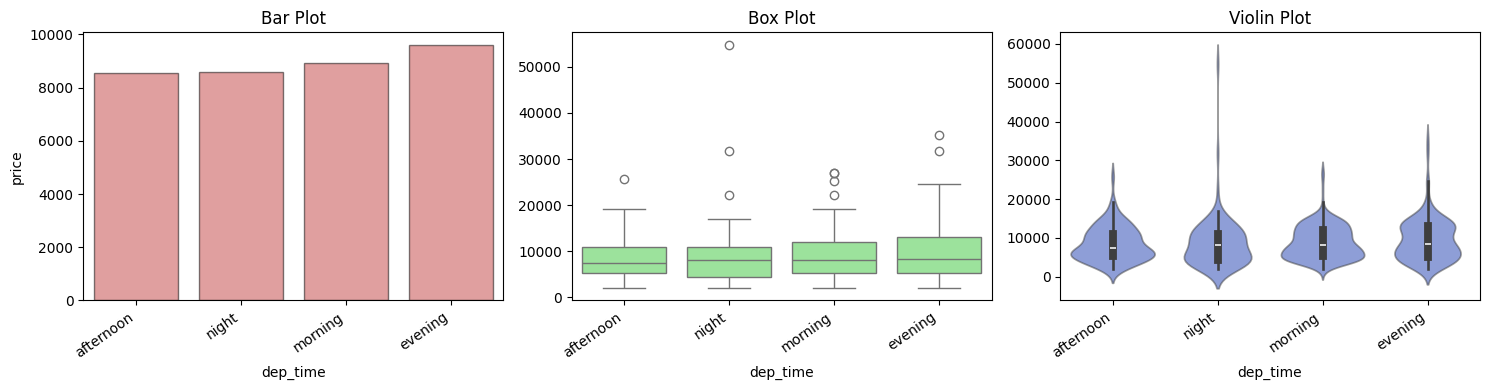

In [50]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 8.4 duration

In [51]:
train.duration

0      965
1      590
2      570
3      170
4      325
      ... 
635    805
636    145
637    590
638    890
639    355
Name: duration, Length: 640, dtype: int64

In [52]:
eda_helper_functions.num_summary(train, "duration")

0      965
1      590
2      570
3      170
4      325
      ... 
635    805
636    145
637    590
638    890
639    355
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.0
5,90.0
10,140.0
25,170.0
50,490.0
75,932.5
90,1415.5
95,1615.0
99,2087.7


,value
mean,633.320312
trimmed mean (5%),597.413194
trimmed mean (10%),570.039062
median,490.000000


,value
var,262882.737615
std,512.720916
IQR,762.500000
mad,330.000000
coef_variance,0.809576


,value
skewness,0.899514
kurtosis,-0.016091


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 2.6582800815521864e-21
Test Statistic       : 0.8860805925307434
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 23.629550690110477
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [53]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    170.0
0.50    490.0
0.75    932.5
Name: duration, dtype: float64

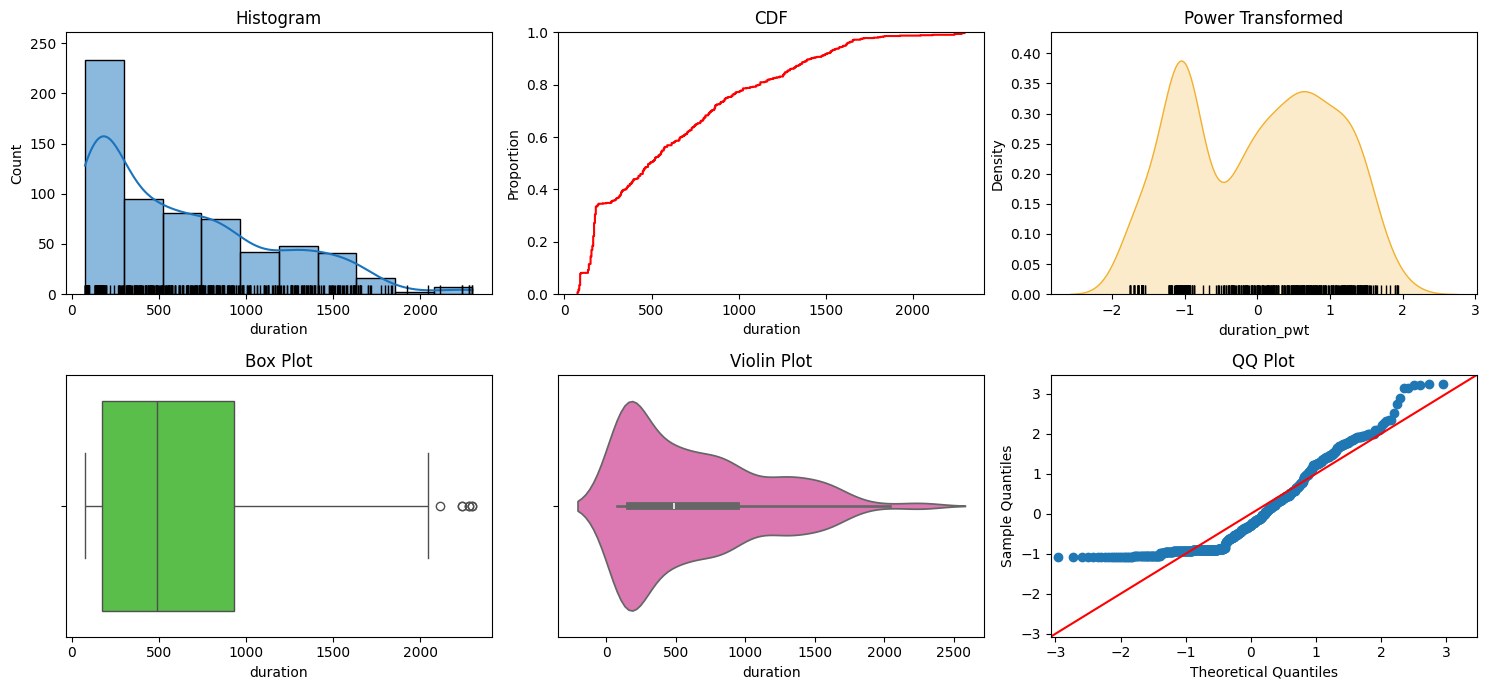

In [54]:
eda_helper_functions.num_univar_plots(train, "duration")

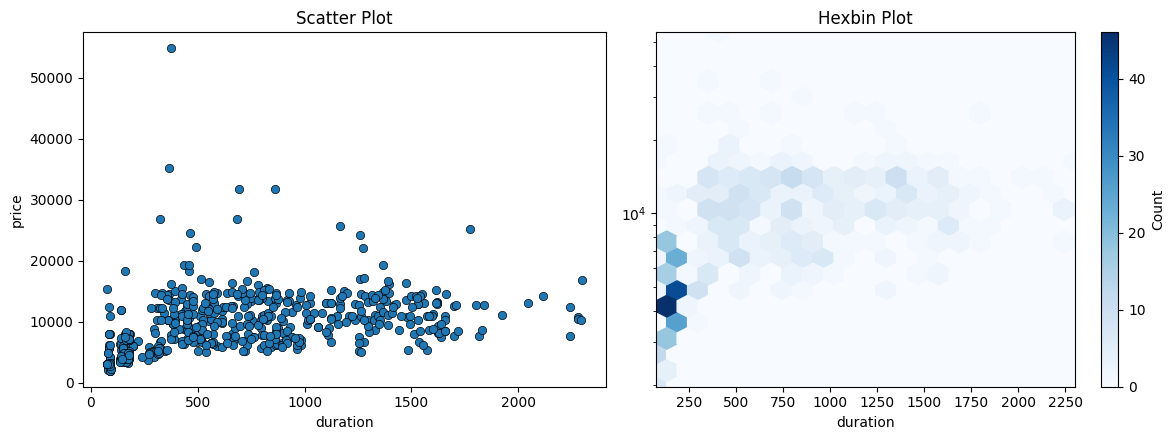

In [55]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [56]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.45815579113150673
- p-value              : 1.5675678811554004e-34
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6785029089561622
- p-value              : 1.6093242702636731e-87
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


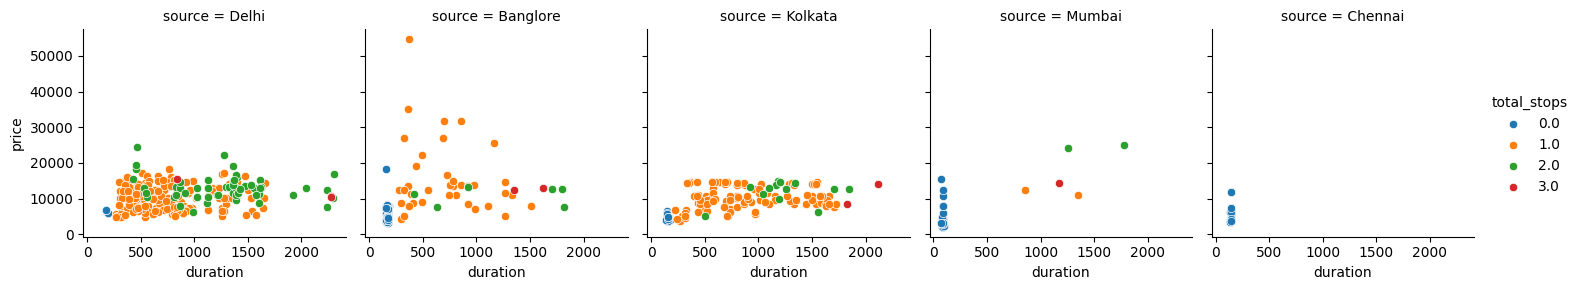

In [57]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

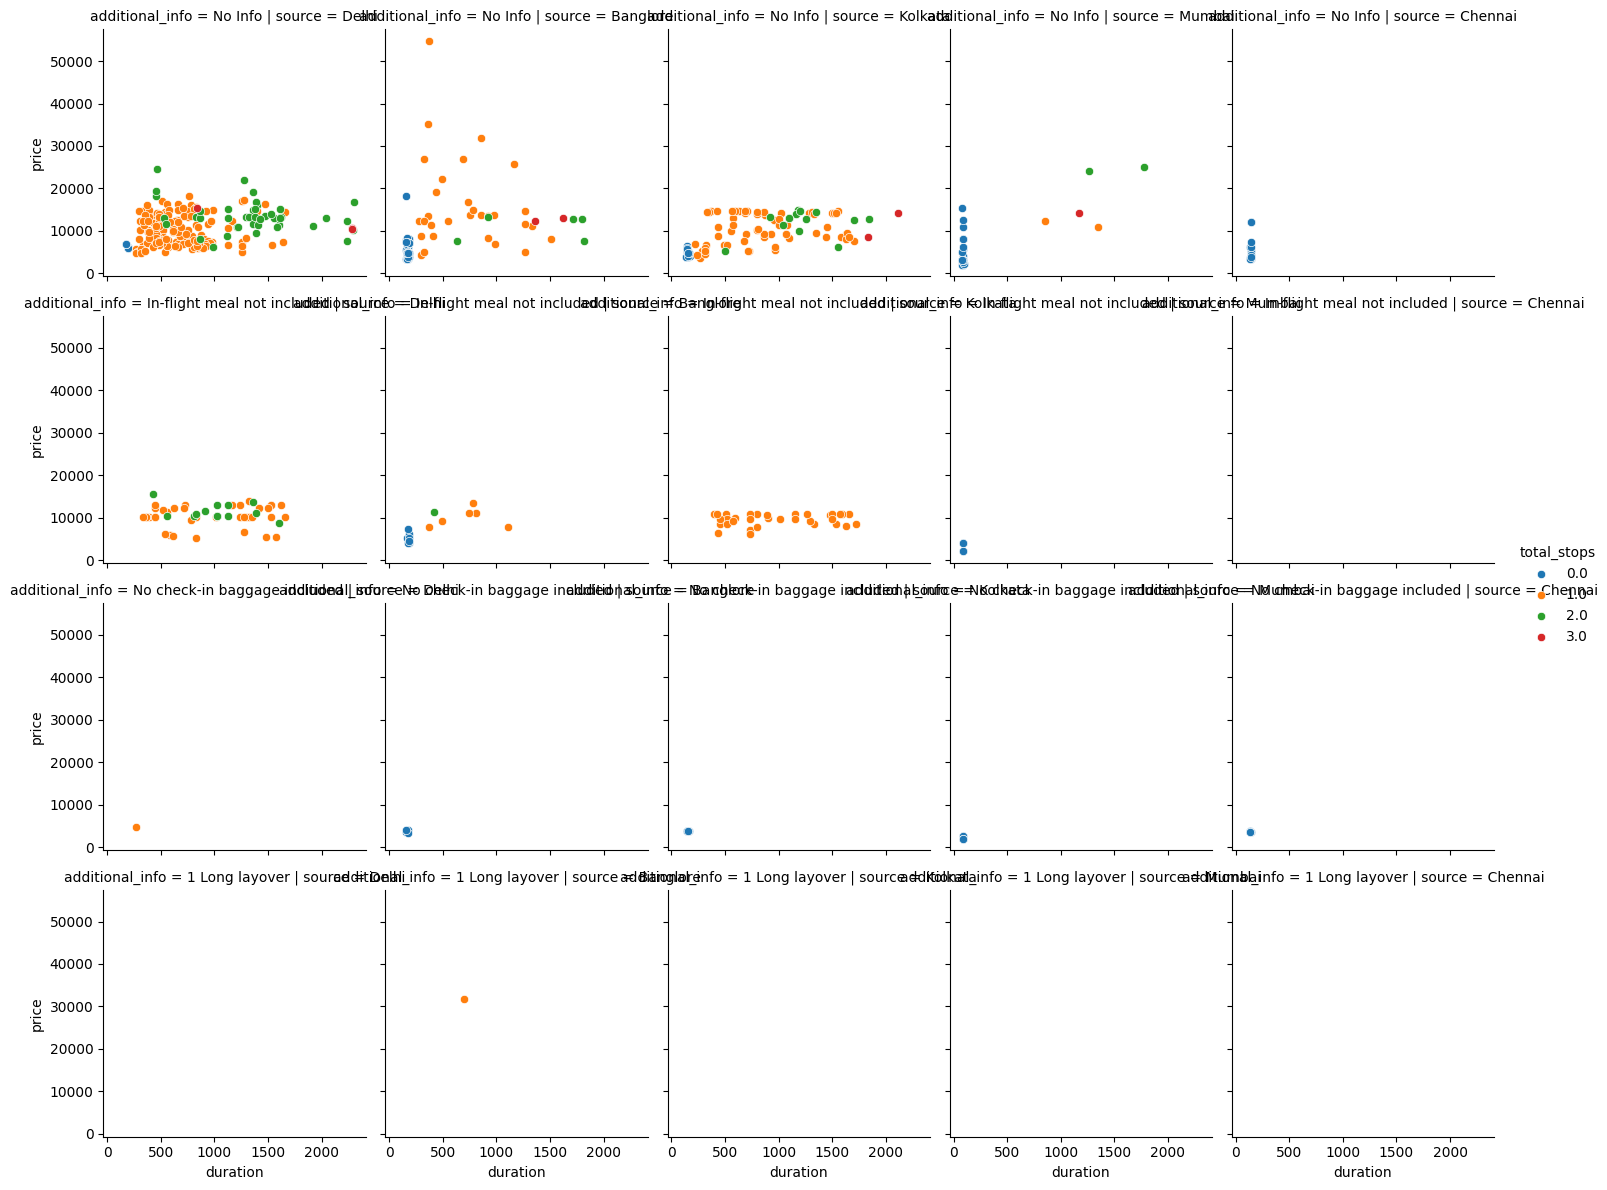

In [58]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [59]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -973.75
Upper Limit : 2076.25


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
530,Air India,2019-03-24,Kolkata,Banglore,2024-05-26 12:00:00,2024-05-26 23:15:00,2115,3.0,No Info,14221
335,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-26 05:30:00,2024-05-26 18:50:00,2240,2.0,No Info,12341
358,Air India,2019-04-09,Delhi,Cochin,2024-05-26 05:55:00,2024-05-26 19:15:00,2240,2.0,No Info,7711
293,Air India,2019-06-15,Delhi,Cochin,2024-05-26 05:15:00,2024-05-26 19:15:00,2280,3.0,No Info,10703
359,Air India,2019-05-27,Delhi,Cochin,2024-05-26 05:15:00,2024-05-26 19:15:00,2280,3.0,No Info,10493
599,Air India,2019-03-03,Delhi,Cochin,2024-05-26 05:00:00,2024-05-26 19:15:00,2295,2.0,No Info,10283
617,Jet Airways,2019-03-06,Delhi,Cochin,2024-05-26 05:25:00,2024-05-26 19:45:00,2300,2.0,No Info,16914


### 8.5 additional_info

In [60]:
eda_helper_functions.cat_summary(train, "additional_info")

0                          No Info
1      In-flight meal not included
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638    In-flight meal not included
639                        No Info
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 4 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,4
top,No Info
freq,512


,count,percentage
category,,
No Info,512,0.800000
In-flight meal not included,107,0.167187
No check-in baggage included,20,0.031250
1 Long layover,1,0.001563


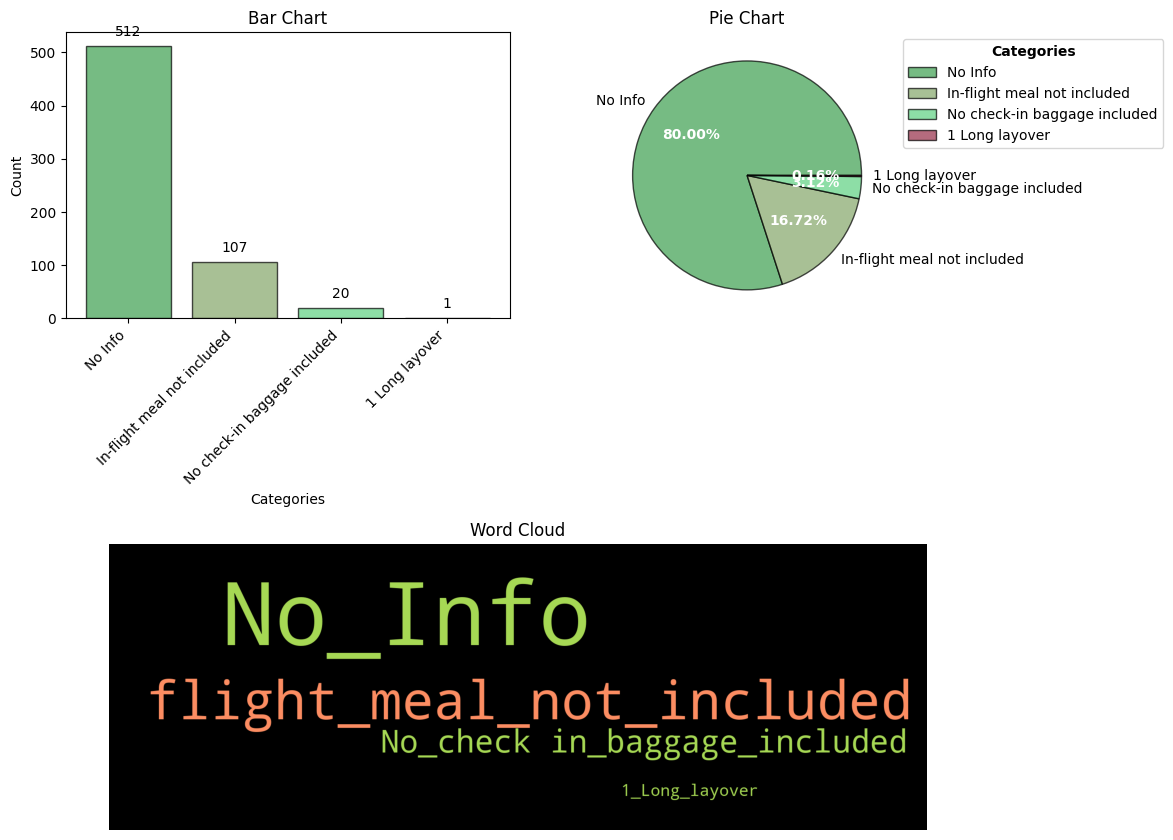

In [61]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

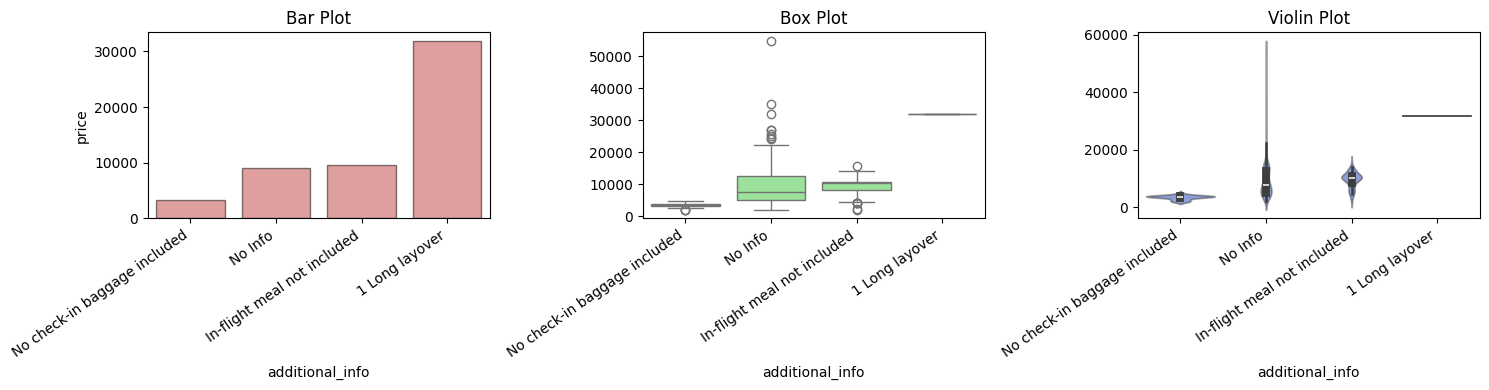

In [62]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

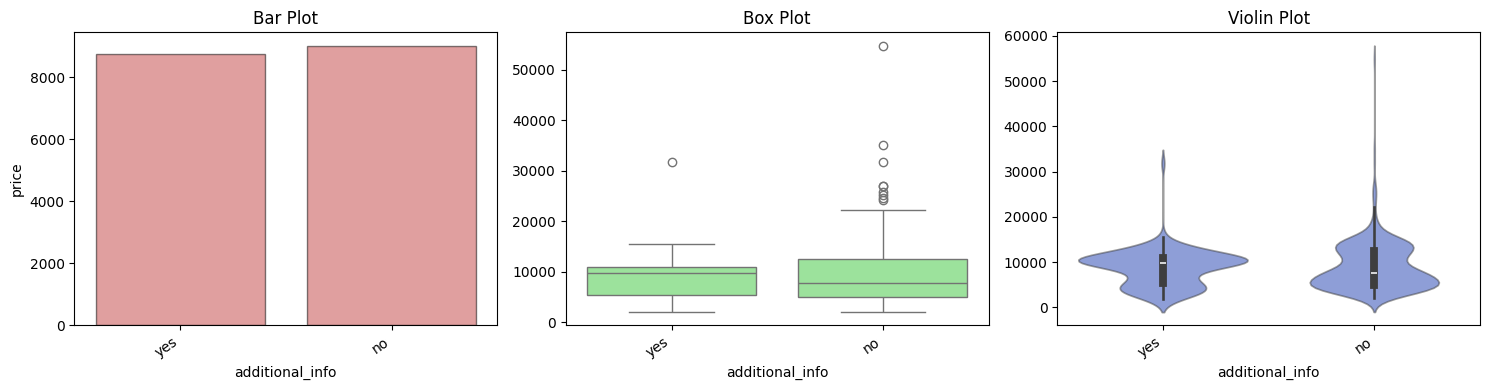

In [63]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

- `additional_info` has severely rare categories
- Converted it into a binary feature for further analysis

## 9. Automated EDA

In [64]:
# from ydata_profiling import ProfileReport

In [65]:
# report = ProfileReport(train)

In [66]:
# report.to_file(output_file="output.html")